In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Task Setup

First, we set up a reversal learning task, modeled after the task used in Kahnt, Park et al. (2008).
There are three rules (or states) that determine the reward delivery:

1. 20:80 Choosing left (right) yield rewards in 20% (80%) of the time.
2. 80:20 Choosing left (right) yield rewards in 80% (20%) of the time.
3. 50:50 Choosing left (right) yield rewards in 50% (50%) of the time.

Subjects perform two blocks and 100 trials per block. 
As in the original the task rule changes (reverses) according to the following rules:

1. Reversals occur after 16 trials in the current rule or
2. Reversals occur after the subject chooses the better option in 70% of the cases and there were at least 10 trials with the current rule.

In [9]:
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2)

states = {
            "0": {"p_r": np.array([0.2, 0.8]), "a_correct": [1]},
            "1": {"p_r": np.array([0.8, 0.2]), "a_correct": [0]},
            "2": {"p_r": np.array([0.5, 0.5]), "a_correct": [0, 1]},
        }

task_vars.states = states
task_vars.n_trials_reversal_min = 10
task_vars.n_trials_reversal_max = 16
task_vars.p_correct_reversal_min = 0.7
task_vars.reward = 1
task_vars.noreward = 0

task = rl.task.ReversalLearningTask(task_vars=task_vars)
task

Reversal learning task with the states (rules):
  {'0': {'p_r': array([0.2, 0.8]), 'a_correct': [1]}, '1': {'p_r': array([0.8, 0.2]), 'a_correct': [0]}, '2': {'p_r': array([0.5, 0.5]), 'a_correct': [0, 1]}}

# Agent

Next, we set up an dual learning rate agent to perform the task with known parameters $\alpha_{win}$, $\alpha_{loss}$ and $\beta$:

In [10]:
agent_vars = rl.agent.AgentVars()
agent_vars.beta = 3
agent_vars.alpha_win = 0.7
agent_vars.alpha_loss = 0.4
agent = rl.agent.DualLearningRateAgent(agent_vars=agent_vars, n_options=task_vars.n_options)
agent

Dual learning rate agent with
  alpha_win = 0.7
  alpha_loss = 0.4
  beta = 3

# Interaction

Now, we can let the agent perform the task:

In [11]:
np.random.seed(1)
df = rl.interaction.agent_task_interaction(task, agent)
df.head(10)

,trial,block,state,p_r_0,p_r_1,r,a,corr,p_a_0,v_a_0,p_a_1,v_a_1,ll
0,0.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.500000,0.700000,0.500000,0.0,-0.693147
2,2.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.890903,0.910000,0.109097,0.0,-0.115520
3,3.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.938774,0.973000,0.061226,0.0,-0.063181
4,4.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.948778,0.583800,0.051222,0.0,-0.052581
5,5.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.852129,0.350280,0.147871,0.0,-0.160017
6,6.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.740936,0.210168,0.259064,0.0,-0.299841
7,7.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.652604,0.126101,0.347396,0.0,-0.426785
8,8.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.593464,0.075660,0.406536,0.0,-0.521779
9,9.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.556503,0.722698,0.443497,0.0,-0.586083


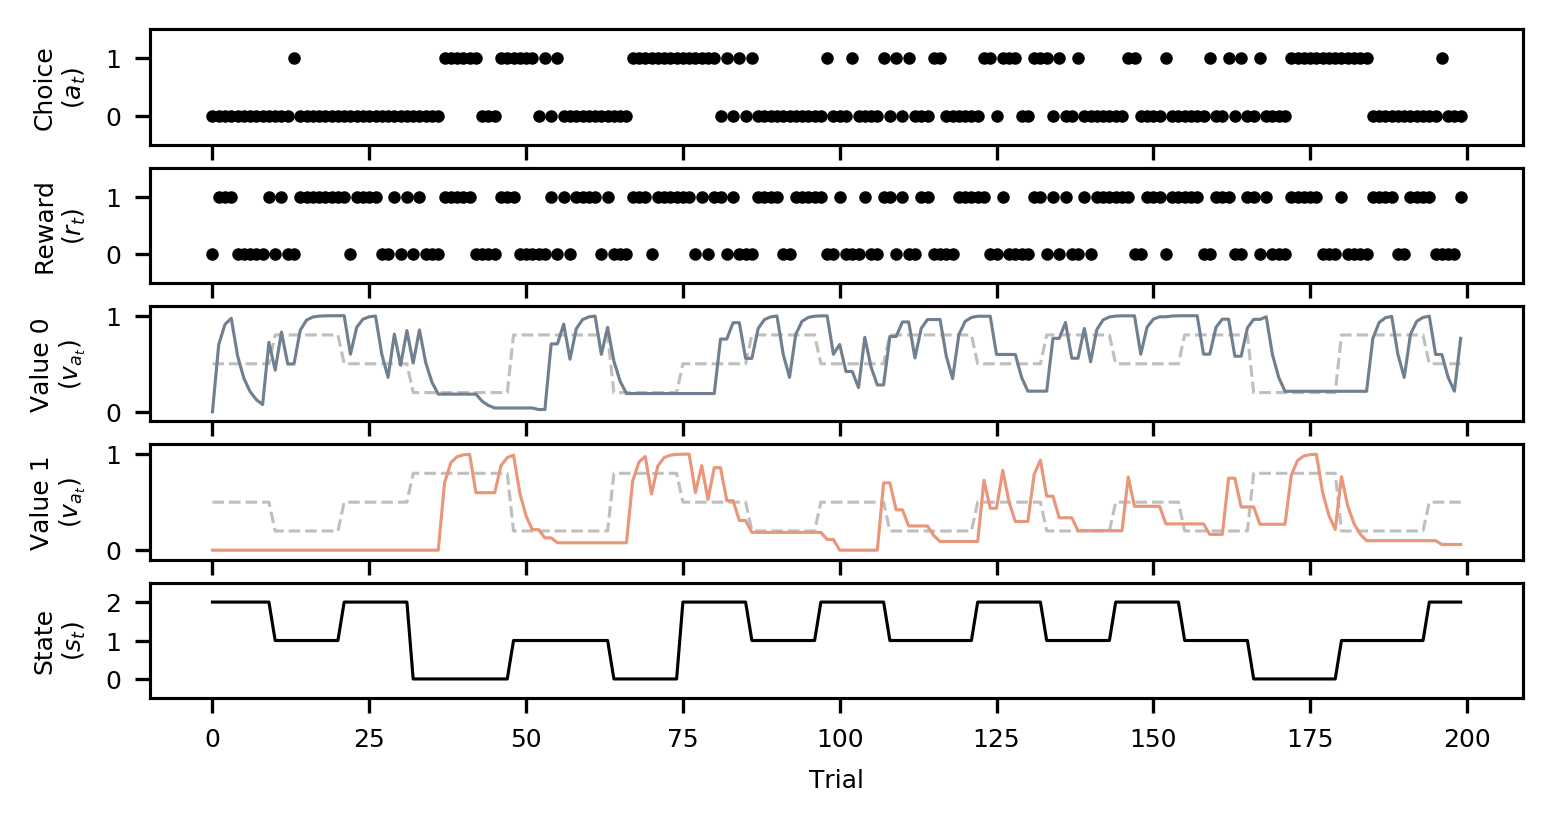

In [33]:
rl.plots.plot_data(data=df);

# Estimation

Given the behavioural data, we can try to estimate the agent's parameters:

In [24]:
parameters = ['alpha_win', 'alpha_loss', 'beta']
bounds = {'alpha_win': (0, 1), 'alpha_loss': (0, 1), 'beta': (0, 20)}
est_vars = rl.estimation.EstimationVars(task_vars,
                                        agent_class=rl.agent.DualLearningRateAgent,
                                        parameters=parameters,
                                        bounds=bounds,
                                        n_sp=10)
est = rl.estimation.Estimation(est_vars)

In [25]:
agent

Dual learning rate agent with
  alpha_win = 0.7
  alpha_loss = 0.4
  beta = 3

In [26]:
est.llh(x=[agent.agent_vars.alpha_win,
           agent.agent_vars.alpha_loss,
           agent.agent_vars.beta],
        data=df,
        agent_vars=agent_vars)

87.6797238348713

In [27]:
result = est.estimate(data=df)
result

(85.29289549816926,
 -93.24037154799132,
 [1.0, 0.2918083392195115, 3.199196728980959])

The estimated parameters are close to, but not identical to the true parameters. We can simulate data from an agent using the estimated parameters and compare the prediction to the original data on different measures:

In [29]:
est_agent_vars = rl.agent.AgentVars(alpha_win=result[2][0],
                                    alpha_loss=result[2][1],
                                    beta=result[2][2])
est_agent = rl.agent.DualLearningRateAgent(agent_vars=est_agent_vars, n_options=2)
est_agent

Dual learning rate agent with
  alpha_win = 1.0
  alpha_loss = 0.2918083392195115
  beta = 3.199196728980959

In [30]:
np.random.seed(1)
pred = rl.interaction.agent_task_interaction(task=task, agent=est_agent)
pred.head()

,trial,block,state,p_r_0,p_r_1,r,a,corr,p_a_0,v_a_0,p_a_1,v_a_1,ll
0,0.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.500000,1.000000,0.500000,0.0,-0.693147
2,2.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.960804,1.000000,0.039196,0.0,-0.039985
3,3.0,0.0,2.0,0.5,0.5,1.0,0.0,1.0,0.960804,1.000000,0.039196,0.0,-0.039985
4,4.0,0.0,2.0,0.5,0.5,0.0,0.0,1.0,0.960804,0.708192,0.039196,0.0,-0.039985


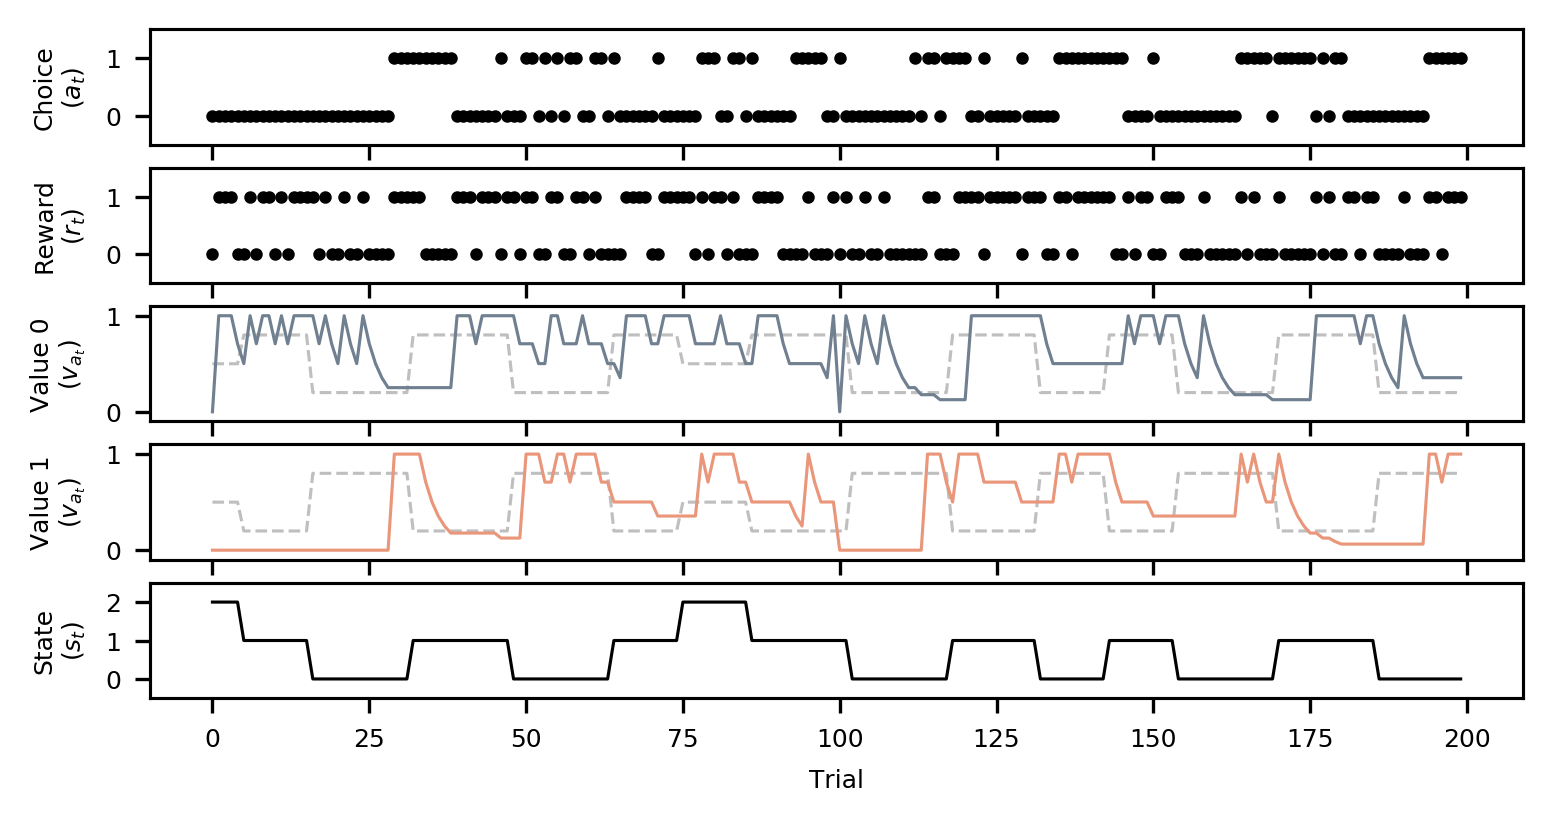

In [32]:
rl.plots.plot_data(pred);

TODO: What measures to look at here?

# Recovery

In [34]:
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2)

states = {
            "0": {"p_r": np.array([0.2, 0.8]), "a_correct": [1]},
            "1": {"p_r": np.array([0.8, 0.2]), "a_correct": [0]},
            "2": {"p_r": np.array([0.5, 0.5]), "a_correct": [0, 1]},
        }

task_vars.states = states
task_vars.n_trials_reversal_min = 10
task_vars.n_trials_reversal_max = 16
task_vars.p_correct_reversal_min = 0.7
task_vars.reward = 1
task_vars.noreward = 0

task = rl.task.ReversalLearningTask(task_vars=task_vars)
task

Reversal learning task with the states (rules):
  {'0': {'p_r': array([0.2, 0.8]), 'a_correct': [1]}, '1': {'p_r': array([0.8, 0.2]), 'a_correct': [0]}, '2': {'p_r': array([0.5, 0.5]), 'a_correct': [0, 1]}}

In [38]:
# Set up agent
agent_vars = rl.agent.AgentVars(alpha_win=np.nan,
                                alpha_loss=np.nan,
                                beta=np.nan)
agent = rl.agent.DualLearningRateAgent(agent_vars=agent_vars,
                                       n_options=task.task_vars.n_options)
agent

Dual learning rate agent with
  alpha_win = nan
  alpha_loss = nan
  beta = nan

In [39]:
# Set up parameter ranges
alpha_win_values = {'variable': np.linspace(0, 1.0, 10), 'low':0.1, 'medium':0.3, 'high':0.6}
alpha_loss_values = {'variable': np.linspace(0, 1.0, 10), 'low':0.1, 'medium':0.3, 'high':0.6}
beta_values = {'variable':np.linspace(1, 10, 10), 'low':3, 'medium':5, 'high':10}
parameter_values = {'alpha_win':alpha_win_values,
                    'alpha_loss':alpha_loss_values,
                    'beta':beta_values}

In [41]:
# Set up estimation
est_vars = rl.estimation.EstimationVars(task_vars=task_vars,
                                        agent_class=rl.agent.DualLearningRateAgent,
                                        parameters=['alpha_win', 'alpha_loss', 'beta'],
                                        bounds={'alpha_win': (0, 1),
                                                'alpha_loss': (0, 1),
                                                'beta': (0, 20)},
                                        n_sp=1)
est = rl.estimation.Estimation(est_vars=est_vars)

In [42]:
recovery_results = rl.recovery.run_recovery(task, agent, est, parameter_values)

In [43]:
recovery_results.head()

,variable,alpha_win,alpha_loss,beta,alpha_win_hat,alpha_loss_hat,beta_hat,n_trials,n_blocks,n_sp,alpha_win_level,alpha_loss_level,beta_level
0,alpha_win,0.000000,0.1,3.0,0.000000,0.000000,0.000000,100,2,1,variable,low,low
1,alpha_win,0.111111,0.1,3.0,0.027866,0.113625,7.708058,100,2,1,variable,low,low
2,alpha_win,0.222222,0.1,3.0,0.084938,0.261709,5.463052,100,2,1,variable,low,low
3,alpha_win,0.333333,0.1,3.0,0.825416,0.180224,3.157557,100,2,1,variable,low,low
4,alpha_win,0.444444,0.1,3.0,0.000000,0.000000,0.000000,100,2,1,variable,low,low


In [44]:
recovery_results.to_csv('recovery-results.csv')

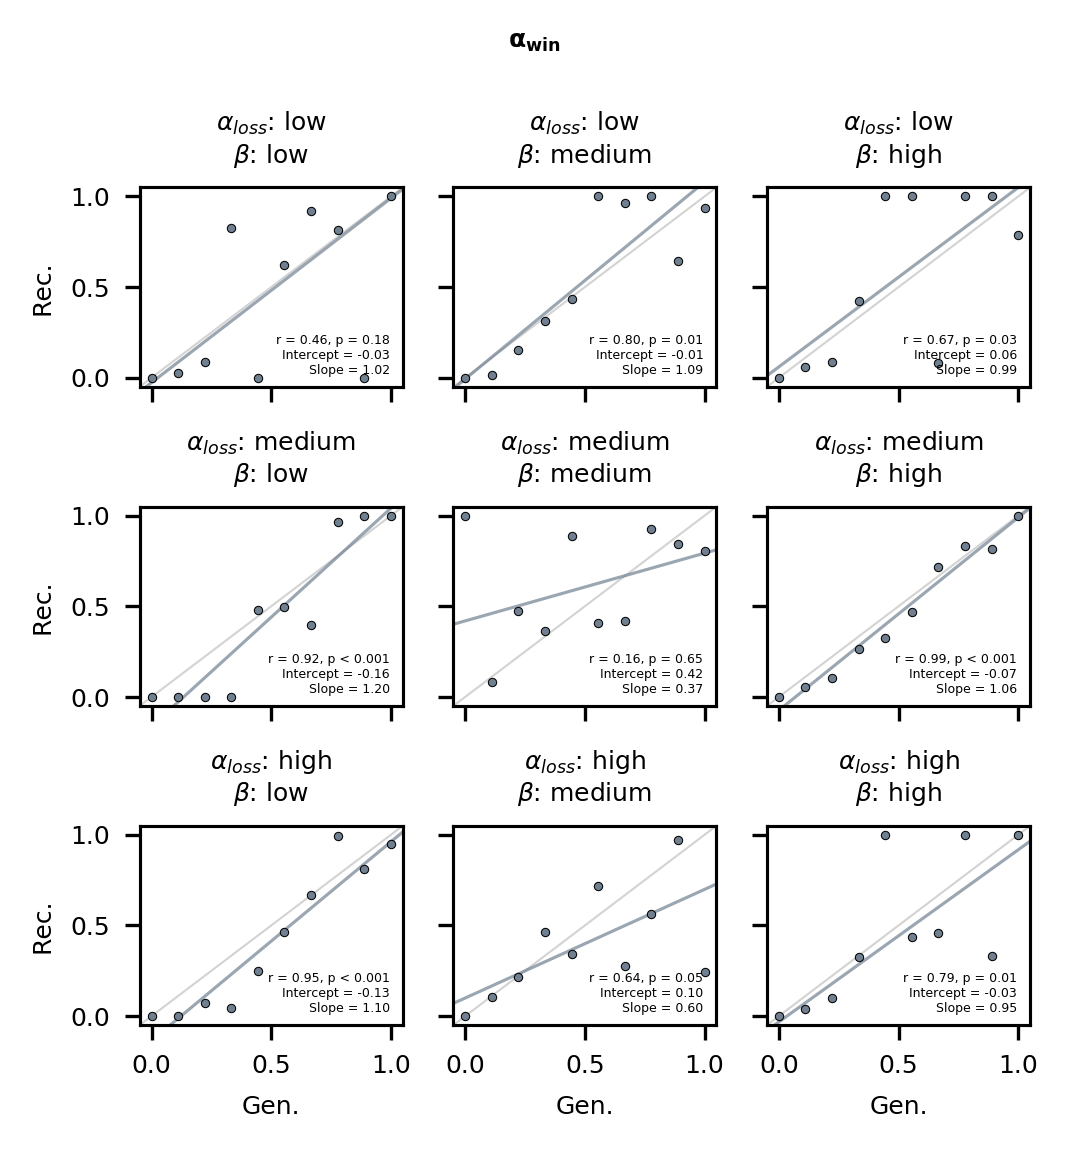

In [45]:
rl.plots.plot_recovery_results(recovery_results,
                      'alpha_win',
                      ticks=np.linspace(0, 1, 3),
                      limits=[-0.05, 1.05]);

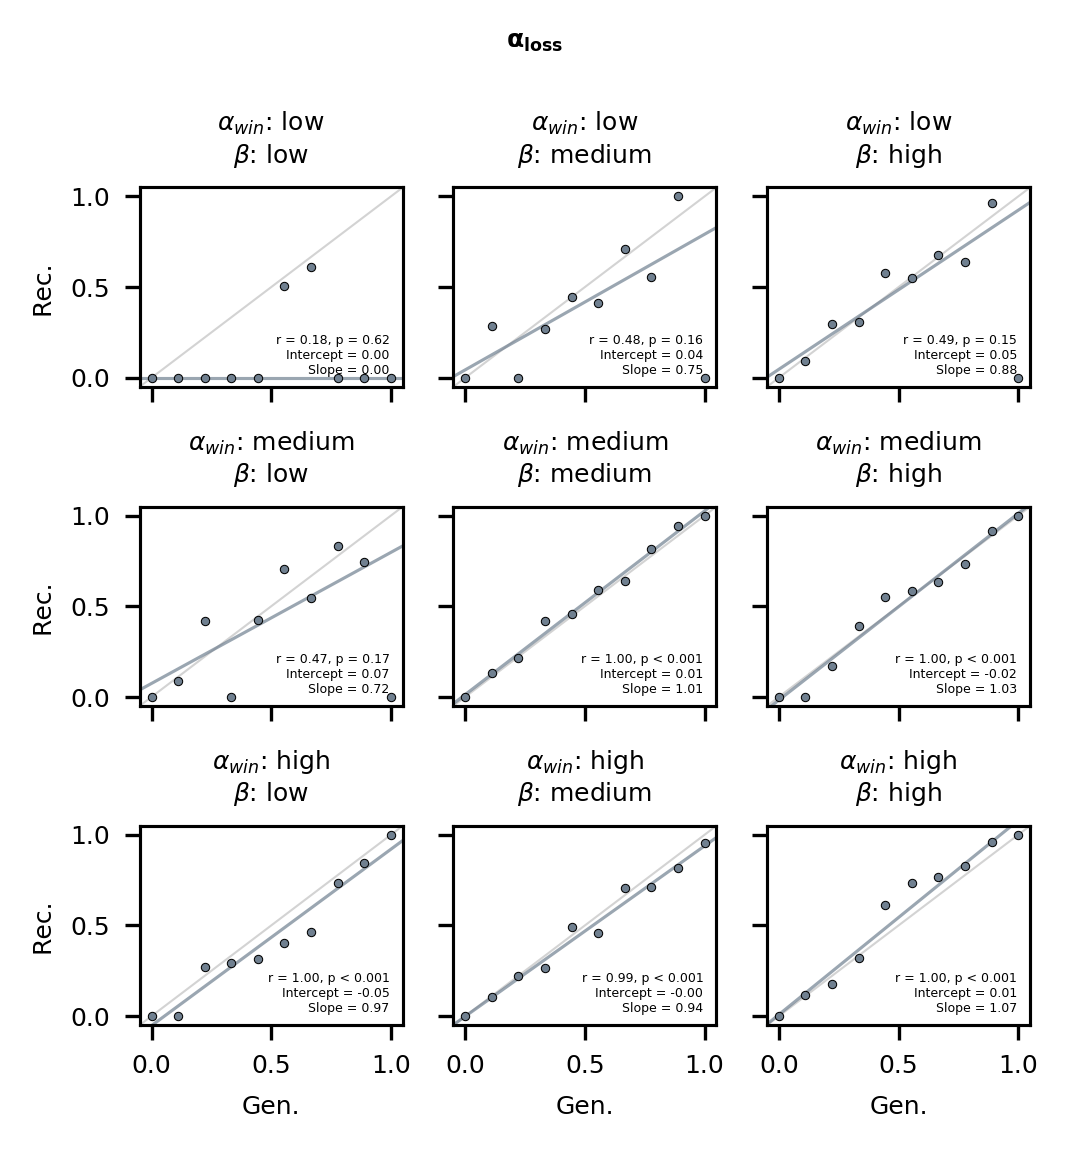

In [46]:
rl.plots.plot_recovery_results(recovery_results,
                      'alpha_loss',
                      ticks=np.linspace(0, 1, 3),
                      limits=[-0.05, 1.05]);

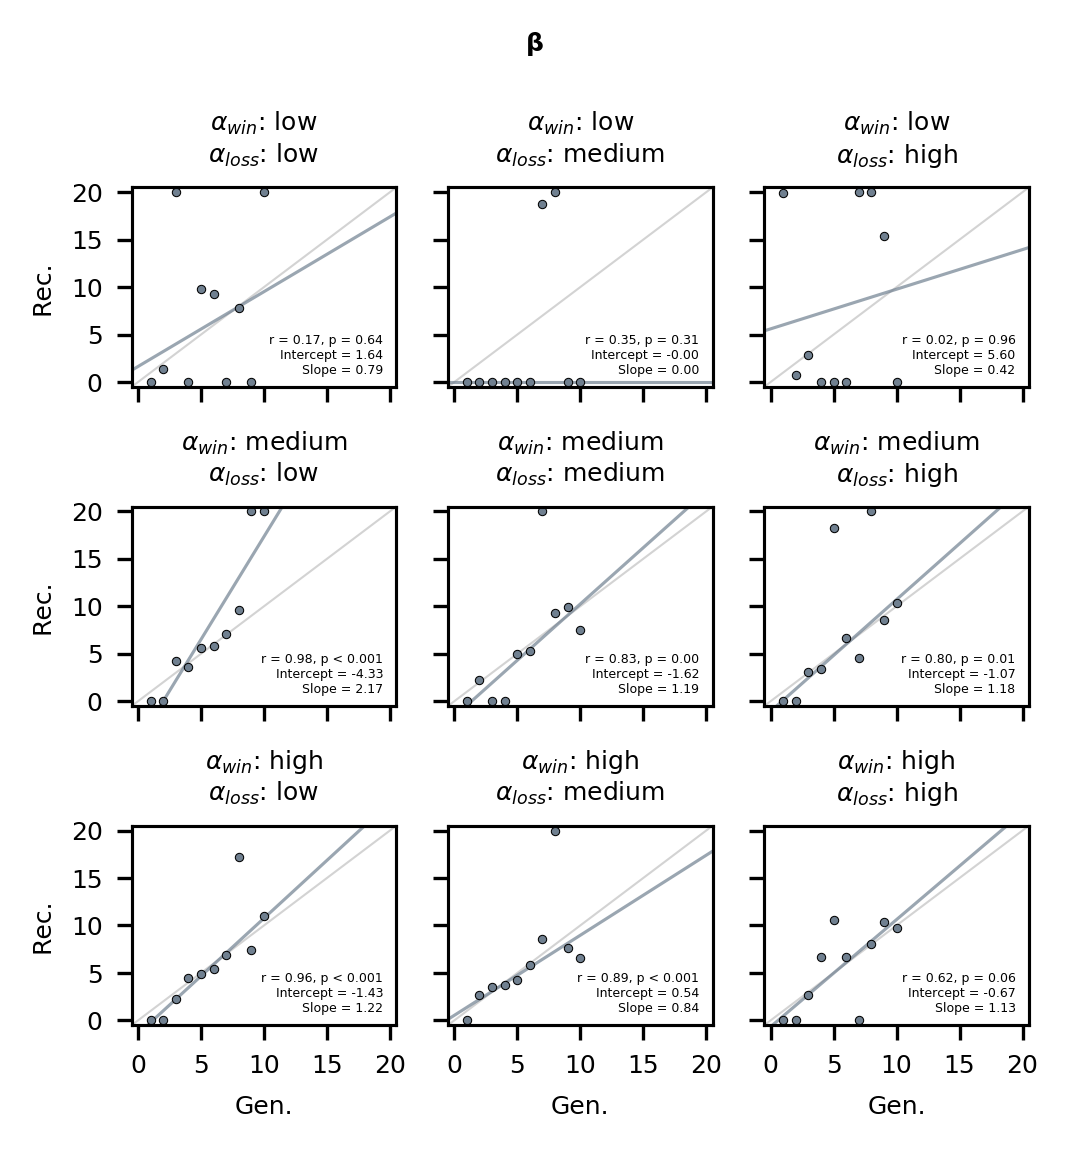

In [47]:
rl.plots.plot_recovery_results(recovery_results,
                      'beta',
                      ticks=np.linspace(0, 20, 5),
                      limits=[-0.5, 20.5]);